In [51]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Metal) on Apple Silicon")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Cpu seems to be faster at everything so just hard coding that here
device = torch.device("cpu")

# set seed for repoducibility
torch.manual_seed(999)

Using MPS (Metal) on Apple Silicon


**Incompressible Momentum Conservation (Navier-Stokes Equations in 2D):** $ \frac{\partial \mathbf{u}}{\partial t} + (\mathbf{u} \cdot \nabla) \mathbf{u} = -\frac{1}{\rho} \nabla p + \nu \nabla^2 \mathbf{u} + \mathbf{g} $

**Incompressibility Condition (Conservation of Mass):** $\nabla \cdot \mathbf{u} = 0$

Here $\rho$ is the density [$\frac{kg}{m^3}$], $p(x, y, t)$ is the pressure field [$Pa$], $\mathbf{u}(x, y, t) = (u(x, y, t), v(x, y, t))$ is the flow velocity field [$\frac{m}{s}$], $\nu$ is the kinematic viscosity [$\frac{m^2}{s}$], and $\mathbf{g}$ is the gravitational field [$\frac{m}{s^2}$].

Next, to turn these equations into a dimensionless form we define the following scales: <br>
$L = $ characteristic length [m]<br>
$U = $ characteristic velocity [m/s]<br>
$T = \frac{L}{U}$ characteristic time [s]<br>
$P = \rho U^2$ characteristic pressure (when dynamic effects dominate) [Pa]<br>

such that:
$$\mathbf{r}^* = \frac{\mathbf{r}}{L}$$
$$\nabla^*=L\nabla$$
$$\mathbf{u}^* = \frac{\mathbf{u}}{U}$$
$$t^* = \frac{t}{T}$$
$$p^* = \frac{p}{P}$$

this then results in the two following dimentionless equation: <br>
$$ \frac{\partial \mathbf{u^*}}{\partial t^*} + (\mathbf{u^*} \cdot \nabla^*) \mathbf{u^*} = -\nabla^* p^* + \frac{1}{Re} \nabla^{*2} \mathbf{u^*} + \frac{1}{Fr^2} \hat g $$ 
$$ \nabla^* \cdot \mathbf{u^*} = 0$$

with the following two dimentionless quantities:
$$ Re = \frac{U L}{\nu} \text{ (Reynolds number)}$$ 
$$ Fr = \frac{U}{\sqrt{gL}} \text{ (Froude number)} $$

**Assumptions Used:** <br>
**1)** Slow Flow leading to constant density $M = \frac{U}{c} << 1$ <br>
**2)** Constant in z-direction (2d flow) <br>
**3)** Constant viscosity

**Problem:** Fast Open Air

**Solution Steps:**
1) Advection: use the explicit MacCormack method to solve $\frac{\partial \mathbf{u^*}}{\partial t^*} + (\mathbf{u^*} \cdot \nabla^*)\mathbf{u^*} = 0$ with second order error in both space and time<br>
2) Diffusion: use an explicit Euler scheme to solve $\frac{\partial \mathbf{u^*}}{\partial t^*} = \frac{1}{Re} \nabla^{*2} \mathbf{u^*}$ with second order error in space but first order time
3) Body force: use an explicit Euler method to solve $\frac{\partial \mathbf{u^*}}{\partial t^*} = \frac{1}{Fr^2} \hat{g}$ with second order error in space but first order time
4) Pressure solve: Jacobi itteration method to solve $\nabla^{*2} p^* = \nabla^* \cdot \mathbf{u^*}$
5) Pressure projection: Use pressure to update velocities
6) CFL condition on dt & Repeat

In [52]:
rho = 1.225 # Density of air at room temperature [kg/m^3]
nu = 1.5e-5 # kinematic viscosity of air at room temperature [m^2/s]
g = 9.8 # gravitational constant [m/s^2]

U = 25 # Characteristic velocity [m/s]
L = 5 # Characteristic length [m]
T = L / U # Characteristic time [s]
P = rho * (U**2) # Characteristic pressure [Pa]

Re = U * L / nu # Reynolds number
Fr = U / ((g*L)**(1/2)) # Froude number

In [53]:
# Number of cells in each direction
Nx = Ny = 100

# calculation and non-dimentionalization of grid spacing
dx = L / (Nx +2)
dy = L / (Ny + 2)

dx = dx / L
dy = dy / L

# initialization, padding, and non-dimentionalization of velocity field and inlet velocity
# Characteristic velocity in the x direction and zero velocity in the y direction plus some random noise
u = torch.full((Ny, Nx), U, device=device, dtype=torch.float32)
v = torch.zeros((Ny, Nx), device=device, dtype=torch.float32)

u += torch.empty((Nx, Ny), device=device, dtype=torch.float32).uniform_(-0.5, 0.5)
v += torch.empty((Nx, Ny), device=device, dtype=torch.float32).uniform_(-0.1, 0.1)

u = F.pad(u, pad=(1, 1, 1, 1), mode='constant', value=0)
v = F.pad(v, pad=(1, 1, 1, 1), mode='constant', value=0)

u_inlet = U

u = u / U
v = v / U
u_inlet = u_inlet / U

# initialization, padding, and non-dimentionalization of the pressure field
# Characteristic pressure everywhere
p = torch.full((Nx, Ny), P, device=device, dtype=torch.float32)

p = F.pad(p, pad=(1, 1, 1, 1), mode='constant', value=0)

p = p / P

# craete an dimentionless coordinate grid assosiated with the center positions for each cell
x = torch.arange(Nx+2, device=device).unsqueeze(0).expand(Ny+2, Nx+2) * dx + (0.5 * dx)
y = torch.arange(Ny+2, device=device).unsqueeze(1).expand(Ny+2, Nx+2) * dy + (0.5 * dy)


# HARD CODED FOR NOW USE FUNCTION WHEN FINISHED
dt = 1.0/60
alpha = 0.5

# total dimentionless time the system has run for
total_time = 0.0

In [54]:
def maccormack_advection(u, v, x, y, dt, boundary_conditions, *args, **kwargs):
    '''
    Updates the velocity field using an MacCormack advection scheme.
    
    u*: torch.tensor (H, W) ---> dimensionless horizontal velocity field
    v*: torch.tensor (H, W) ---> dimensionless vertical velocity field
    dt*: float ---> dimensionless time step
    x*: torch.tensor ((H, W)---> dimensionless grid of the x coordinates for the cneter of each cell
    y*: torch.tensor (H, W) ---> dimensionless grid of the y coordinates for the center of each cell
    boundary_conditions: callable function ---> boundary conditions to be applied to u & v along with any additional arguments
    *args : positional arguments for boundary_conditions
    **kwargs : keyword arguments for boundary_conditions

    **Make sure all tensors are on the same device**

    (Predictor step): Semi-Lagrangian technique to interpolate back in time to the previous location 
    and computed the predicted previous velocity field using bilinearinterpolation
    x_p* = x_i* - u*(j, i) * dt*
    y_p* = y_j* - v*(j, i) * dt*
    u_p* = Interpolate_u*(y_p*, x_p*)
    v_p* = Interpolate_v*(y_p*, x_p*)
    (Corrector step): Now, from the predicted location, step forward in time, again using the Semi-Lagrangian technique, 
    to see where the predicted value would arrive
    x_a* = x_p* + u_p*(j, i) * dt*
    y_a* = y_p* + v_p*(j, i) * dt*
    u_a* = Interpolate_u_p*(y_a*, x_a*)
    v_a* = Interpolate_v_p*(y_a*, x_a*)
    Finally, compute the average of the two predicted velocities:
    u* = 0.5(u_p* + u_a*)
    v* = 0.5(v_p* + v_a*)

    Theis scheme should yeild second-order accuracy in both space and time. However, due to it being an explicit method in is not 
    unconditionally stable. The CFL condition for stability is: dt <= dx/u_max

    Returns:
    u*: torch.tensor (H, W) ---> updated horizontal velocity field (Ny x Nx) (not in-place)
    v*: torch.Tensor (H, W) ---> updated vertical velocity field (Ny x Nx) (not in-place)
    '''
    # calculating the predicted previous location and then clamping it to force it to be located within the grid
    x_p = (x - (u*dt)).clamp(0,1)
    y_p = (y - (v*dt)).clamp(0,1)

    # normalizing the values of x and y to be between -1 and 1
    x_p_norm = (x_p * 2) - 1
    y_p_norm = (y_p * 2) -1

    # creating the necesary normalized grid for torch's sample grid method. Shape (N=1, H=Ny, W=Nx, 2->(x, y)) 
    xy_p_grid_norm = torch.stack((x_p_norm, y_p_norm), dim=-1).unsqueeze(0)
    
    # stacking the verticle and horizontal velocity fields into shape (N=1, C=2->(u, v), H=Ny, W=Nx) so we can compute all at once 
    uv_stack = torch.stack((u, v), dim=0).unsqueeze(0)

    # using pytorch's grid sample method to perform bilinear interpolation at predicted points
    uv_p_stack = F.grid_sample(uv_stack, xy_p_grid_norm, mode='bilinear', padding_mode='zeros', align_corners=True).squeeze()
    u_p = uv_p_stack[0]
    v_p = uv_p_stack[1]

    # because this function updates the boundary values need to reset them to their prescibed values before moving forwards
    u_p, v_p = boundary_conditions(u_p, v_p, *args, *kwargs)
    
    # calculating the arival points based on the newly calcualted velocity fields and then clamping it to force it to be located within the grid
    x_a = (x_p + (u_p*dt)).clamp(0,1)
    y_a = (y_p + (v_p*dt)).clamp(0,1)

    # normalizing the values of x and y to be between -1 and 1
    x_a_norm = (x_a * 2) - 1
    y_a_norm = (y_a * 2) -1
    
    # creating the necesary normalized grid for torch's sample grid method. Shape (N=1, H=Ny, W=Nx, 2->(x, y)) 
    xy_a_grid_norm = torch.stack((x_a_norm, y_a_norm), dim=-1).unsqueeze(0)

    # add an extra dimention back to uv_p_stack such that it meets the required input dimention (N=1, C=2->(u, v), H=Ny, W=Nx)
    uv_p_stack = uv_p_stack.unsqueeze(0)
    
    # using pytorch's grid sample method to perform bilinear interpolation at predicted points
    uv_a_stack = F.grid_sample(uv_p_stack, xy_a_grid_norm, mode='bilinear', padding_mode='zeros', align_corners=True).squeeze()
    u_a = uv_a_stack[0]
    v_a = uv_a_stack[1]

    # because this function updates the boundary values need to reset them to their prescibed values before moving forwards
    u_a, v_a = boundary_conditions(u_a, v_a, *args, *kwargs)

    u = 0.5*(u_a + u_p)
    v = 0.5*(v_a + v_p)

    return u, v

In [55]:
def explicit_euler_diffusion(u, v, dt, dx, dy, Re):
    """
    Applies diffusion to the interior velocity field ignoring edges 
    using an explicit Euler scheme with central differencing used to compute the Laplacian.

    Parameters:
    u*: torch.tensor (H, W) ---> dimensionless horizontal velocity field
    v*: torch.tensor (H, W) ---> dimensionless vertical velocity field
    dt*: float ---> dimensionless time step
    dx*: float ---> dimensionless grid spacing in x
    dy*: float ---> dimensionless grid spacing in y
    Re: float ---> Reynolds number

    Equation:
    u*_new = u*_old + ((dt*/Re) * Laplacian(u))
    v*_new = v*_old + ((dt*/Re) * Laplacian(v))

    This scheme should yeild first order accuracy in time while achieving second order accuaracy in space. Due to it being an explicit 
    scheme it is only conditionally stable. The CFL condition for dt is: dt <= (dx**2 * Re) / (U*L)

    Returns:
    u*: torch.Tensor (H, W) ---> updated horizontal velocity field (Ny x Nx) (in-place)
    v*: torch.Tensor (H, W) ---> updated vertical velocity field (Ny x Nx) (in-place)
    """

    # constant used in calculations
    alpha = dt / Re

    # squared grid sizes
    dx2 = dx**2
    dy2 = dy**2
    
    # Compute Laplacian for u using finite differences (only interior points)
    Left = u[1:-1, :-2]
    Right = u[1:-1, 2:]
    Up = u[:-2, 1:-1]
    Down = u[2:, 1:-1]
    Center = u[1:-1, 1:-1]
    laplacian_u = ((Right + Left - (2*Center)) / dx2) + ((Up + Down - (2*Center)) / dy2)

    Left = v[1:-1, :-2]
    Right = v[1:-1, 2:]
    Up = v[:-2, 1:-1]
    Down = v[2:, 1:-1]
    Center = v[1:-1, 1:-1]
    laplacian_v = ((Right + Left - (2*Center)) / dx2) + ((Up + Down - (2*Center)) / dy2)



    # Update the interior points in place using the explicit Euler method
    u[1:-1, 1:-1] += alpha * laplacian_u
    v[1:-1, 1:-1] += alpha * laplacian_v

    return u, v

In [56]:
def explicit_euler_gravity(v, dt, Fr):
    """
    Applies gravity to the interior verticle velocity field ignoring edges using an explicit Euler scheme.

    Parameters:
    v*: torch.tensor (H, W) ---> dimensionless vertical velocity field
    dt*: float ---> dimensionless time step
    Fr: float ---> Fruede number

    Equation:
    v*_new = v*_old + (1/Fr^2) * dt

    This scheme should yeild first order accuracy in time. Due to it being an explicit scheme it is only conditionally stable. 
    The CFL condition for dt is: dt <= Fr

    Returns:
    v*: torch.Tensor (H, W) ---> updated vertical velocity field (Ny x Nx) (in-place)
    """
    # Apply gravity downwards [0][0] is top left and y grows as the first index increases so we want to add
    v[1:-1, 1:-1] += (1 / (Fr**2)) * dt

    return v

In [57]:
def Jacobi_pressure_solver(u, v, p, dt, dx, dy, pressure_boundary_conditions, max_iters=10, tol=1.0e-6):
    '''
    Iteratively solves the Poisson's equation for pressure using the Jacobi method.

    u*: torch.tensor (H, W) ---> dimensionless horizontal velocity field
    v*: torch.tensor (H, W) ---> dimensionless vertical velocity field
    p*: torch.tensor (H, W) ---> dimentionless pressure field
    dt*: float ---> dimensionless time step
    dx*: float ---> dimensionless grid spacing in x
    dy*: float ---> dimensionless grid spacing in y
    pressure_boundary_conditions: callable function ---> boundary conditions to be applied to p
    max_iters: int=100 ---> max number of iterations if convergence is not hit
    tol: float=1.0e-6 ---> once the L2 norm between the current and previous pressure field is less than tol it stops
    
    1) Compute divergence of velocity field:
    div*(u*, v*) = (u*_(i+1,j) - u*_(i,j)) / 2*dx* + (v*_(i,j+1) - v*_(i,j)) / 2*dy*
    
    2) Update pressure:
    p*_(i,j)^(n+1) = 1 / (2 * (1 / dx*^2 + 1 / dy*^2)) * ((p*_(i+1,j)^n + p*_(i-1,j)^n) / dx*^2 + (p*_(i,j+1)^n + p*_(i,j-1)^n) / dy*^2 - div*(u*, v*))

    3) Loop steps 1 & 2 until we reach convergence or max_iters

    This scheme should yeild first order accuracy in time and second order accuracy in space. 
    Due to it being an semi-implicit scheme it is only conditionally stable. However, the CFL condition for 
    it is linked with that for advection: dt <= dx/u_max

    Returns:
    p*: torch.Tensor (H, W) ---> updated pressure field (Ny x Nx) (in-place)
    '''

    # loop "max_iters" number of times
    for i in range(max_iters):
        # calculating the divergence using central differencing
        div = ((u[1:-1, 2:] - u[1:-1, :-2]) / (2*dx)) + ((v[2:, 1:-1] - v[:-2, 1:-1]) / (2*dy))

        p_old = p.clone()
    
        # updating pressure
        p[1:-1, 1:-1] = (1 / (2 * ((1 / (dx**2)) + (1 / (dy**2))))) * ( ((p[1:-1, 2:]+p[1:-1, :-2])/(dx**2)) + ((p[:-2, 1:-1]+p[2:, 1:-1])/(dy**2)) - div)

        # apply boundary conditions
        p = pressure_boundary_conditions(p)

        # calculates the L2 norm between current and previous step to check for convergence
        residual = torch.linalg.norm(p[1:-1, 1:-1] - p_old[1:-1, 1:-1])

        # Checks for convergence
        if residual < tol:
            break
    
    return p

In [58]:
def pressure_projection(u, v, p, dt, dx, dy):
    '''
    Updates the velocity field based on the pressure gradient.
    
    u*: torch.tensor (H, W) ---> dimensionless horizontal velocity field
    v*: torch.tensor (H, W) ---> dimensionless vertical velocity field
    p*: torch.tensor (H, W) ---> dimentionless pressure field
    dt*: float ---> dimensionless time step
    dx*: float ---> dimensionless grid spacing in x
    dy*: float ---> dimensionless grid spacing in y
    
    Update equations:
    u*_(i,j)^(n+1) = u*_(i,j)^n - (dt*/2dx*) * (p*_(i+1,j) - p*_(i-1,j))
    v*_(i,j)^(n+1) = v*_(i,j)^n - (dt*/2dy*) * (p*_(i,j+1) + p*_(i,j-1))

    Returns:
    u*: torch.Tensor (H, W) ---> updated horizontal velocity field (Ny x Nx) (in-place)
    v*: torch.Tensor (H, W) ---> updated vertical velocity field (Ny x Nx) (in-place)
    '''
    # updating velocity fields based on pressure gradient
    u[1:-1, 1:-1] -= ((dt / (2 * dx)) * (p[1:-1, 2:] - p[1:-1, :-2]))
    v[1:-1, 1:-1] -= ((dt / (2 * dy)) * (p[2:, 1:-1] - p[:-2, 1:-1]))
    
    return u, v

In [59]:
def apply_boundary_conditions(u, v, p, u_inlet):
    '''
    Applies boundary conditions to the given velocity and pressure fields.
    
    u*: torch.tensor (H, W) ---> horizontal dimentionless velocity field 
    v*: torch.tensor (H, W) ---> vecticle dimentionless velocity field
    p*: torch.tensor (H, W) ---> dimentionless pressure field
    u_inlet*: float ---> dimentionless inlet velocity
    
    Boundary conditions
    1) Inlet: 
        Velocity: Dirichlet boundary conditions (u=u_inlet, v=0)
        Pressure: Neumann boundary condition (zero pressure gradient)
    2) Outlet: 
        Velocity: Neumann boundary condition (zero velocity gradient)
        Pressure: Neumann boundary condition (zero pressure gradient)
    3) Bottom: 
        Velocity: Dirichlet boundary condition (no slip: u=v=0)
        Pressure: Neumann boundary condition (zero pressure gradient)
    4) Top: 
        Velocity: Neumann & Dirichlet boundary condition (free slip: zero velocity gradient in u, v=0)
        Pressure: Neumann boundary condition (zero pressure gradient)

    Returns:
    u*: torch.Tensor (H, W) ---> updated horizontal velocity field (Ny x Nx) (in-place)
    v*: torch.Tensor (H, W) ---> updated vertical velocity field (Ny x Nx) (in-place)
    p*: torch.Tensor (H, W) ---> updated pressure field (Ny x Nx) (in-place)

    '''
    # Inlet boundary
    u[:, 0] = u_inlet
    v[:, 0] = 0
    p[:, 0] = p[:, 1]
    # Top
    u[0, :] = u[1, :]
    v[0, :] = 0
    p[0, :] = p[1, :]
    # Outlet
    u[:, -1] = u[:, -2]
    v[:, -1] = v[:, -2]
    p[:, -1] = p[:, -2]
    # Bottom
    u[-1, :] = 0
    v[-1, :] = 0
    p[-1, :] = p[-2, :]

    return u, v, p

In [60]:
def velocity_boundary_conditions(u, v, u_inlet):
    '''
    Applies boundary conditions to the given velocity fields.
    
    u*: torch.tensor (H, W) ---> horizontal dimentionless velocity field 
    v*: torch.tensor (H, W) ---> vecticle dimentionless velocity field
    u_inlet*: float ---> dimentionless inlet velocity
    
    Boundary conditions
    1) Inlet: 
        Velocity: Dirichlet boundary conditions (u=u_inlet, v=0)
    2) Outlet: 
        Velocity: Neumann boundary condition (zero velocity gradient)
    3) Bottom: 
        Velocity: Dirichlet boundary condition (no slip: u=v=0)
    4) Top: 
        Velocity: Neumann & Dirichlet boundary condition (free slip: zero velocity gradient in u, v=0)

    Returns:
    u*: torch.Tensor (H, W) ---> updated horizontal velocity field (Ny x Nx) (in-place)
    v*: torch.Tensor (H, W) ---> updated vertical velocity field (Ny x Nx) (in-place)

    '''
    # Inlet boundary
    u[:, 0] = u_inlet
    v[:, 0] = 0

    # Top
    u[0, :] = u[1, :]
    v[0, :] = 0
 
    # Outlet
    u[:, -1] = u[:, -2]
    v[:, -1] = v[:, -2]

    # Bottom
    u[-1, :] = 0
    v[-1, :] = 0

    return u, v

In [61]:
def pressure_boundary_conditions(p):
    '''
    Applies boundary conditions to the given pressure field.
    
    p*: torch.tensor (H, W) ---> dimentionless pressure field
    
    Boundary conditions
    1) Inlet: 
        Pressure: Neumann boundary condition (zero pressure gradient)
    2) Outlet: 
        Pressure: Neumann boundary condition (zero pressure gradient)
    3) Bottom: 
        Pressure: Neumann boundary condition (zero pressure gradient)
    4) Top: 
        Pressure: Neumann boundary condition (zero pressure gradient)

    Returns:
    p*: torch.Tensor (H, W) ---> updated pressure field (Ny x Nx) (in-place)
    '''
    # Inlet boundary
    p[:, 0] = p[:, 1]
    # Top
    p[0, :] = p[1, :]
    # Outlet
    p[:, -1] = p[:, -2]
    # Bottom
    p[-1, :] = p[-2, :]

    return p

In [62]:
def cfl_condition(u, v, dx, dy, Re, Fr, alpha=1):
    '''
    Calculates the largest time step that satisfies the Courant-Friedrichs-Lewy (CFL) condition condition 
    for advection, diffusion, and gravty.

    **For maximum efficientcy have u and v be on the cpu as if they aren't data will neeed to be transfered**

    Parameters:
    u*: torch.tensor (H, W) ---> dimensionless horizontal velocity field
    v*: torch.tensor (H, W) ---> dimensionless vertical velocity field
    dx*: float ---> dimensionless grid spacing in x 
    dy*: float ---> dimensionless grid spacing in y
    Re: float ---> Reynolds number
    Fr: float ---> Froude number
    alpha: float ---> safety factor used to scale the maximum allowable value down for stability (0,1)

    CFL Conditions:
    (advection): dt <= min(dx / max(|u|), dy / max(|v|))

    (diffusion): dt <= min(dx^2, dy^2) * Re / 4

    (gravity): dt <= Fr
    
    Returns:
    dt*: float ---> updated dt (not in-place)
        
    '''
    # calculates the max absolute values of the u and v velocity fields
    u_max = u.abs().max().item()  
    v_max = v.abs().max().item()  

    # calculates the highest allowable dt value during advection
    dt_advection = min(dx / u_max, dy / v_max)

    # calculates the highest allowable dt value during diffusion
    dx2 = dx**2
    dy2 = dy**2
    dt_diffusion = min(dx2, dy2) * Re / 4

    # chooses the smallest dt of the three such that it satisfies all condition
    dt_gravity = Fr

    # scales dt my the specified safety factor    
    dt = min(dt_advection, dt_diffusion, dt_gravity, 0.01) * alpha

    return dt

In [63]:
def update(u, v, p, dx, dy, Re, Fr, alpha, u_inlet, total_time, velocity_boundary_conditions, pressure_boundary_conditions, cfl_condition, advection, diffusion, gravity, pressure_solver, projection):
    '''
    runs a single update sequence

    u*: torch.tensor (H, W) ---> dimensionless horizontal velocity field
    v*: torch.tensor (H, W) ---> dimensionless vertical velocity field
    p*: torch.tensor (H, W) ---> dimentionless pressure field
    dx*: float ---> dimensionless grid spacing in x 
    dy*: float ---> dimensionless grid spacing in y
    Re: float ---> Reynolds number
    Fr: float ---> Froude number
    alpha: float ---> safety factor used to scale the maximum allowable value down for stability (0,1)
    u_inlet*: float ---> dimentionless inlet velocity
    velocity_boundary_conditions: callable function ---> boundary conditions to be applied to u & v
    pressure_boundary_conditions: callable function ---> boundary conditions to be applied to p
    cfl_conditions: callable function ---> updates dt
    advection: callable function ---> updates u & v based on particle motion
    diffusion: callable function ---> updates u & v based on viscis effects
    gravity: callable function ---> updes u & v based onn graviational effects
    pressure_solver: callable function ---> updates p based on u & v
    projection: updates u & v based on p

    1) Advection: use the explicit MacCormack method to solve du*/dt* = (u* dot del*)u* = 0 with second order error in both space and time<br>
    2) Diffusion: use an explicit Euler scheme to solve du*/dt* = (1/Re) Laplacian*(u*) with second order error in space but first order time
    3) Body force: use an explicit Euler method to solve du*/dt* = (1/Fr^2)g^hat with second order error in space but first order time
    4) Pressure solve: Jacobi itteration method to solve Laplacian*(p*) = div*(u*)
    5) Pressure projection: Use pressure to update velocities
    6) CFL condition on dt & Repeat
    '''
    dt = cfl_condition(u, v, dx, dy, Re, Fr, alpha)
    u, v = advection(u, v, x, y, dt, velocity_boundary_conditions, u_inlet)
    u, v = velocity_boundary_conditions(u, v, u_inlet)
    u, v = diffusion(u, v, dt, dx, dy, Re)
    u, v = velocity_boundary_conditions(u, v, u_inlet)
    v = gravity(v, dt, Fr)
    u, v = velocity_boundary_conditions(u, v, u_inlet)
    p = pressure_solver(u, v, p, dt, dx, dy, pressure_boundary_conditions)
    p = pressure_boundary_conditions(p)
    u, v = projection(u, v, p, dt, dx, dy)
    u, v = velocity_boundary_conditions(u, v, u_inlet)
    total_time += dt
    return u, v, p, dt

In [64]:
def plot_pressure(p):
    plt.figure(figsize=(6, 6))
    plt.imshow(p, origin='lower', cmap='viridis', extent=[0, p.shape[1], 0, p.shape[0]])
    plt.colorbar(label='Pressure')
    plt.title("Pressure Field")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().invert_yaxis()
    plt.show()

def plot_velocity_streamlines(u, v, x, y):
    # Create a grid for streamlines

    plt.figure(figsize=(6, 6))
    plt.streamplot(x, y, u, v, density=1.5, linewidth=1, arrowsize=1)
    plt.title("Velocity Streamlines")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().invert_yaxis()
    plt.show()

def plot_pressure_and_velocity_streamlines(p, u, v, x, y):
    # Plot pressure field
    plot_pressure(p)
    
    # Plot velocity field as streamlines
    plot_velocity_streamlines(u, v, x, y)

In [65]:
# %timeit cfl_condition(u, v, dt, dx, dy, Re, Fr, alpha)

In [66]:
# %timeit apply_boundary_conditions(u, v, p, u_inlet)

In [67]:
# %timeit maccormack_advection(u, v, x, y, dt, velocity_boundary_conditions, u_inlet)

In [68]:
# %timeit explicit_euler_diffusion(u, v, dt, dx, dy, Re)

In [69]:
# %timeit explicit_euler_gravity(v, dt, Fr)

In [70]:
# %timeit Jacobi_pressure_solver(u, v, p, dt, dx, dy)

In [71]:
# %timeit pressure_projection(u, v, p, dt, dx, dy)

In [72]:
# %%time
# u, v, p = apply_boundary_conditions(u, v, p, u_inlet)
# for i in range(100):
#     dt = cfl_condition(u, v, dx, dy, Re, Fr, alpha)
#     u, v = maccormack_advection(u, v, x, y, dt, velocity_boundary_conditions, u_inlet)
#     u, v = explicit_euler_diffusion(u, v, dt, dx, dy, Re)
#     v = explicit_euler_gravity(v, dt, Fr)
#     p = Jacobi_pressure_solver(u, v, p, dt, dx, dy)
#     u, v = pressure_projection(u, v, p, dt, dx, dy)

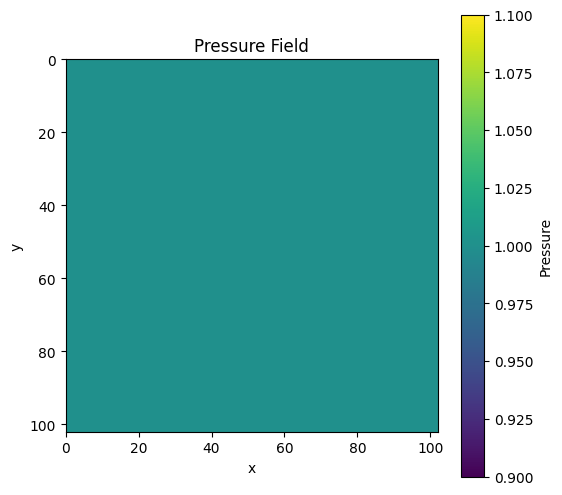

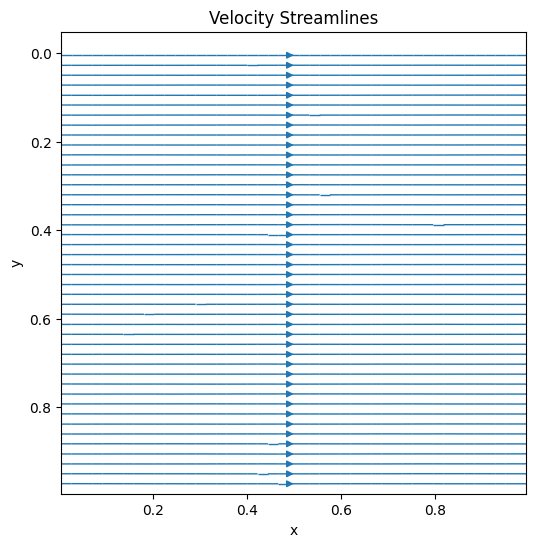

In [73]:
u, v, p = apply_boundary_conditions(u, v, p, u_inlet)
plot_pressure_and_velocity_streamlines(p, u, v, x.numpy(), y.numpy())

In [74]:
%%time

for i in range(1000):
    u, v, p, dt = update(u, v, p, dx, dy, Re, Fr, alpha, u_inlet, total_time, velocity_boundary_conditions, pressure_boundary_conditions, cfl_condition, maccormack_advection, explicit_euler_diffusion, explicit_euler_gravity, Jacobi_pressure_solver, pressure_projection)

CPU times: user 2.13 s, sys: 100 ms, total: 2.23 s
Wall time: 1.88 s


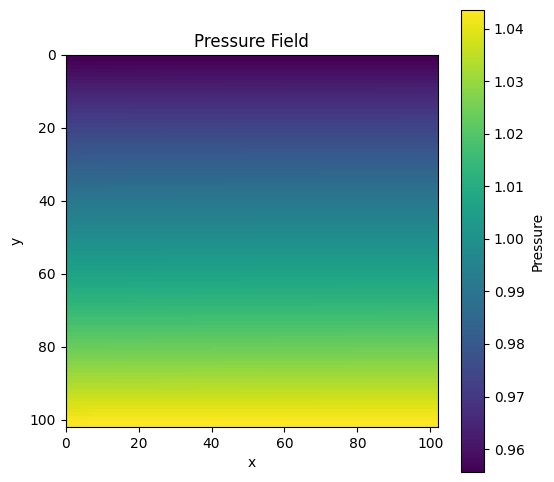

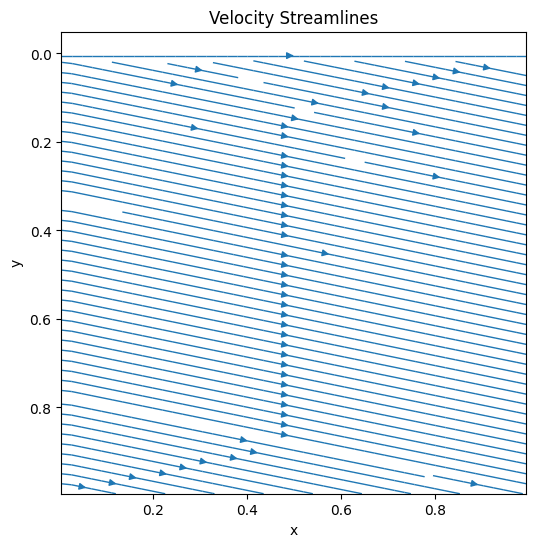

In [75]:
plot_pressure_and_velocity_streamlines(p, u, v, x.numpy(), y.numpy())